<a href="https://colab.research.google.com/github/TongshuWu1/RL_CSE337_TonyWu/blob/main/lab2_mdp_Tony.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 2: Markov Decision Problems

# Exercise 1: Grid World
Compute the value funnction for the example 4.1 in the book.







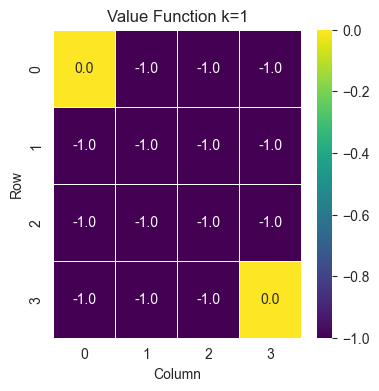

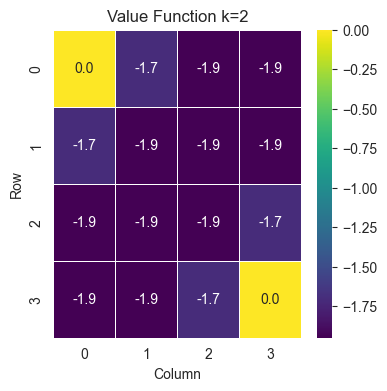

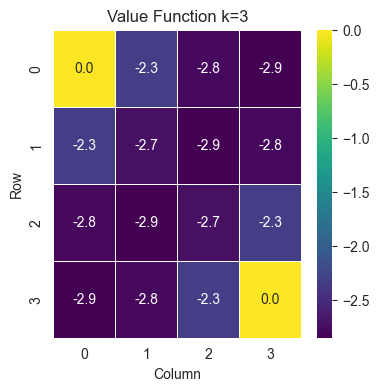

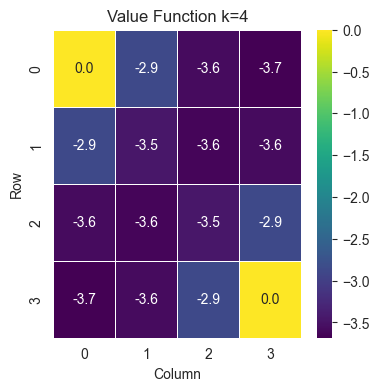

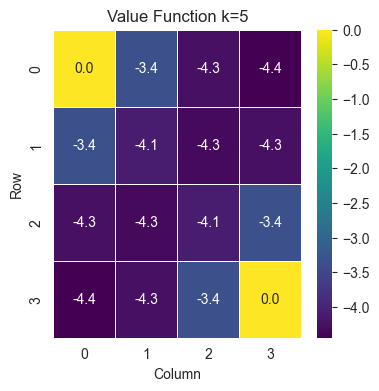

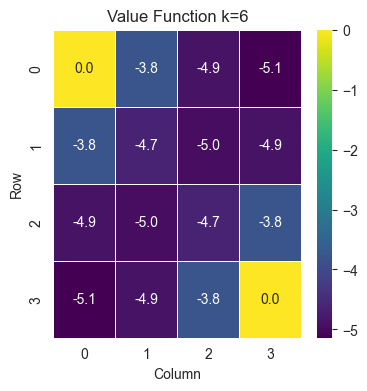

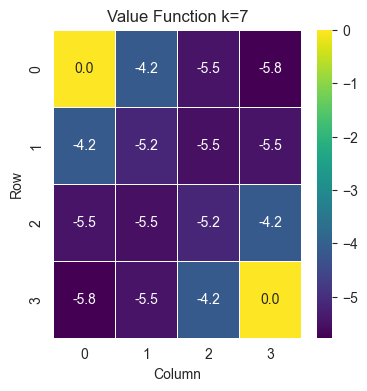

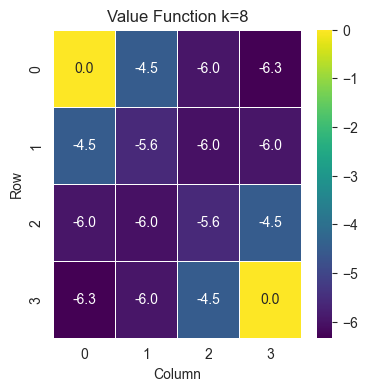

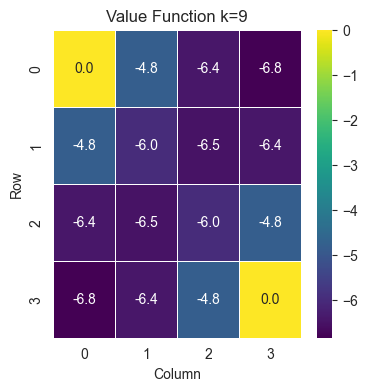

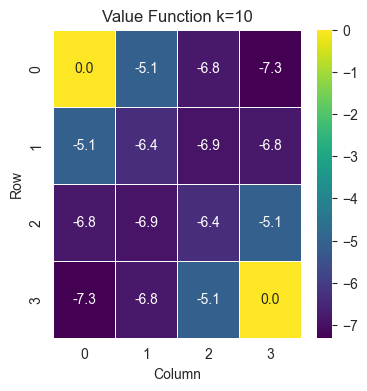

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

V = np.zeros(16)
gamma = 0.95  # Discount factor
V_old = np.zeros(16)

actions = [-4, 4, -1, 1]
pi = 0.25

def step(s, a):
    if s == 0 or s == 15:
        return s, 0

    s_prime = s + a

    # boundary checks
    if s < 4 and a == -4:
        s_prime = s
    if s >= 12 and a == 4:
        s_prime = s
    if s % 4 == 0 and a == -1:
        s_prime = s
    if s % 4 == 3 and a == 1:
        s_prime = s

    return s_prime

for k in range(10):
    V_old = V.copy()
    for s in range(16):
        if s == 0 or s == 15:
            continue

        v = 0
        for a in actions:
            s_prime = step(s, a)
            v += 0.25 * (-1 + gamma * V_old[s_prime])
        V[s] = v

    # PLOT after each sweep
    V_grid = V.reshape((4, 4))
    plt.figure(figsize=(4, 4))
    sns.heatmap(V_grid, annot=True, cmap="viridis", fmt=".1f", linewidths=.5)
    plt.title("Value Function k=%d" % (k+1))
    plt.xlabel("Column")
    plt.ylabel("Row")
    plt.show()


# Exercise 2: Grid World
Compute the optimal policy




In [41]:
def optimal_policy(r, c, V_grid):
    actions = []
    values = []

    # Up
    if r > 0:
        actions.append("up")
        values.append(V_grid[r-1, c])
    # Down
    if r < V_grid.shape[0] - 1:
        actions.append("down")
        values.append(V_grid[r+1, c])
    # Left
    if c > 0:
        actions.append("left")
        values.append(V_grid[r, c-1])
    # Right
    if c < V_grid.shape[1] - 1:
        actions.append("right")
        values.append(V_grid[r, c+1])

    best_idx = np.argmax(values)
    return actions[best_idx], values[best_idx]

best_action, best_value = optimal_policy(2, 2, V_grid)
print("Best action:", best_action, "with value:", best_value)


Best action: down with value: -5.100095738473345


# Exercise 3: Grid World
In the following gym environment, compute the value function using Monte Carlo.

Run the following code in your local machine. You can run in on colab, but you will not see the animation.

In [42]:
## Install https://github.com/damat-le/gym-simplegrid
!pip install gym_simplegrid


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


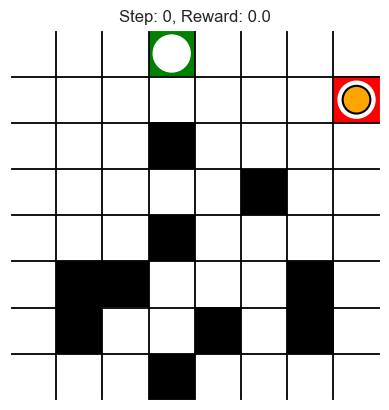

Location (1,7) t=0 reward=-1.0
Location (1,6) t=1 reward=0.0
Location (0,6) t=2 reward=0.0
Location (0,5) t=3 reward=0.0
Location (0,4) t=4 reward=0.0
Location (0,5) t=5 reward=0.0
Location (0,6) t=6 reward=0.0
Location (1,6) t=7 reward=0.0
Location (1,7) t=8 reward=0.0
Location (1,6) t=9 reward=0.0

Estimated Value Function (8x8 grid) under π:
[[-1.54 -1.66 -1.7   0.   -2.94 -4.7  -5.66 -7.84]
 [-2.43 -2.21 -2.44 -2.57 -5.3  -5.47 -6.56 -7.54]
 [-3.18 -3.01 -3.15  0.   -7.17 -6.79 -6.71 -7.99]
 [-3.88 -3.55 -3.68 -4.63 -6.87  0.   -7.18 -7.63]
 [-3.23 -2.91 -3.83  0.   -6.45 -7.   -7.52 -7.5 ]
 [-5.06  0.    0.   -9.17 -7.51 -8.48  0.   -7.95]
 [-6.28  0.   -8.42 -8.11  0.   -6.43  0.   -7.9 ]
 [-8.75 -6.76 -7.08  0.   -7.35 -5.92 -7.37 -7.64]]


In [43]:
import gymnasium as gym
import gym_simplegrid
import numpy as np
from collections import defaultdict

START_LOC = 15
GOAL_LOC = 3
# Define the initial location and the goal location in the grid.
# Each grid cell has an a number from 0 to 63.
options ={
    'start_loc': START_LOC,
    'goal_loc': GOAL_LOC
}

env = gym.make('SimpleGrid-8x8-v0', render_mode='human')
obs, info = env.reset(seed=1, options=options)
done = env.unwrapped.done

for t in range(10):
    if done:
        break
    action = env.action_space.sample()   # Random action
    obs, reward, done, _, info = env.step(action)

    grid_size = 8
    row = obs // grid_size
    col = obs % grid_size
    print("Location (", row, ",", col, ") t=",t, " reward=", reward, sep="")

# env.close()

env_mc = gym.make('SimpleGrid-8x8-v0', render_mode=None)

EPISODES = 200
GAMMA = 0.99
MAX_STEPS = 100

n_states = env_mc.observation_space.n
n_actions = env_mc.action_space.n

returns_sum = defaultdict(float)
returns_count = defaultdict(float)
V = np.zeros(n_states)

for ep in range(EPISODES):
    obs, info = env_mc.reset(seed=None, options=options)
    episode = []
    done = False
    steps = 0

    while not done and steps < MAX_STEPS:
        action = np.random.choice(n_actions, p=[1/n_actions]*n_actions)
        next_obs, reward, terminated, truncated, info = env_mc.step(action)
        done = terminated or truncated
        episode.append((obs, reward))
        obs = next_obs
        steps += 1

    G = 0
    visited_states = set()
    for t in reversed(range(len(episode))):
        s, r = episode[t]
        G = GAMMA * G + r
        if s not in visited_states:
            returns_sum[s] += G
            returns_count[s] += 1
            V[s] = returns_sum[s] / returns_count[s]
            visited_states.add(s)

V_grid = V.reshape((8, 8))
print("\nEstimated Value Function (8x8 grid) under π:")
print(np.round(V_grid, 2))
